# SAR range-Doppler processing simulator #

based on the book *Digital signal processing techniques and applications in radar image processing*, a book by Bu-Chin Wang.

The technique of *Doppler beam sharpening* was developed by Carl Wiley of the Goodyear Aircraft Corporation as a means of improving the spatial resolution of long wavelength imaging radar. The longer wavelengths required unfeasibly larger antennas to achieve the same spatial resolution, so Wiley developed a means of using the Doppler shift in the echoes to achieve a much higher resolution. This technique is now often referred to as aperture synthesis, as it allows a small antenna to achieve the effective resolution of a much larger, synthesised antenna (or aperture). Note that technically speaking, beam sharpening and aperture synthesis are slightly different techniques.


We will focus only on *airborne-based radar* image data processing; therefore, the
estimation of Doppler centroid and Doppler frequency ambiguity, which is critical
for *satellite-based squint SAR systems*, is not addressed here.

Simplifications taken in this simulator:

-- ignore the background objects, so that the received signal is noise-free,

-- the target is an ideal reflector and stationary; therefore, motion compensation
is not required,

-- ignore the effect of the inclination angle. The slant range is considered equal to
the ground range.

We are simulating here the *broadside* (versus squint) **stripmap mode**. 


The M x N array of 2D radar image raw data is formed by M bursts of radar pulses with N samples each. The purpose of SAR processing, ideally, is to convert the raw data into a **single pixel** in the final processed image.

The raw data synthethized in *SAR-Raw-Data-Simulator* from a point target have a waveform with size M × N in both time and azimuth directions. The spread in time is caused by the time duration of the transmitted LFM pulse. The spread in azimuth is because the target is under the radar illumination during the whole path of synthetic aperture length, which causes the radar to receive the echo signal for the period during which the radar moves through the whole path of synthetic aperture length.

Range-Doppler processor can do three major functions of SAR data processing: range compression, range cell migration correction, and azimuth compression.

From here:
http://envisat.esa.int/handbooks/asar/CNTR2-6-1-2-3.html

The range-Doppler algorithm is the most commonly used algorithm for processing continuously collected SAR data into an image. It is computationally efficient and, for typical spaceborne imaging geometries, the range-Doppler algorithm is an accurate approximation to the exact SAR transfer function. Thus, the algorithm is phase-preserving and Single Look Complex (SLC) images formed with the range-Doppler algorithm can be used for applications such as interferometry. The range-Doppler algorithm is designed for continuously collected data, in contrast to SPECAN which is best suited to bursty data, and can process the full azimuth bandwidth.

SAR processing is a two-dimensional problem. In the raw SAR data, the signal energy from a point target is spread in range and azimuth, and the purpose of SAR focussing is to collect this dispersed energy into a single pixel in the output image. In range, the signal is spread by duration of the linear FM transmitted pulse. In azimuth, the signal is spread by the duration it is illuminated by the antenna beam, or the synthetic aperture. As a point target passes through the azimuth antenna beam, the range to the target changes. On the scale of the wavelength, this range variation causes a phase variation in the received signal as a function of azimuth. This phase variation over the synthetic aperture corresponds to the Doppler bandwidth of the azimuth signal, and allows the signal to be compressed in the azimuth direction. *The range variation to point target can result in a variation in the range delay to the target that is larger than the range sample spacing, resulting in what is called range migration.* This range migration of the signal energy over several range bins must be corrected before azimuth compression can occur. The range-Doppler algorithm performs this correction very efficiently in the range-time, azimuth-frequency domain.


<img src="http://slideplayer.com/slide/5932625/20/images/22/Range-Doppler+algorithm.jpg" alt="Illustration of SAR single point-target imaging." title="Range-Doppler processing.." />

We are simulating the basic RDA case (a) from the Figure above.

import sys
sys.version
sys.version_info

In [11]:
import numpy as np
import math
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = 12, 8  # that's default image size for this interactive session

We need some information about the radar system:

h -- altitude of the flying vehicle (satellite or plane)

v -- the speed of the vehicle

PRI -- pulse repetition interval

PRF -- pulse repetition frequency = 1 / PRI

time7s -- how long we fly and send the set of pulses

lambd -- our carrier signal frequency fc = 0.0311 in the case of X-band and 9.65GHz
In this simulator, we set fc = 10GHZ, hence, lambd = 0.03m.

# LFM pulsed signal #

We work with a pulsed LFM (linear frequency modulation) waveform. Other possibilities to modulate the carrier signal for sending the data would be amplitude and different types of frequency modulation.

A0 = 1 amplititude of the transimtter signal

Tp -- pulse duration

fc -- carrier frequency

alpha7s -- LFM pulse chirp rate (range FM rate α = 4e12 Hz/s in the example from the book)


In [12]:
# radar beam carrier frequency (Hz)
fc = 1.0e10 
# light speed (speed of wave) (m/s)
c = 3.0e8
# wavelength of carrier = c/fc (m)
lambd = c / fc
# amplitude of transimtter signal (m)
A0 = 1.0
# pulse repetition frequency (Hz)
PRF = 500
# pulse duration (s)
Tp = 6.033e-6
#######################################################
## below the params from the book, but they are not
## giving the same visualizations as in the book; so
## we had to change them as in the next set
#######################################################
# LFM pulse chirp rate (Range FM rate) (Hz/s)
alpha7s = 4.0e12
# number of time samples total
tot_samples = 260
# range sampling frequency
fs = 30e6
#######################################################
## these are the params we had to change compared to
## the book to make the visualizations as in the book
#######################################################
# LFM pulse chirp rate (Range FM rate) (Hz/s)
alpha7s = 2.0e12
# number of time samples total
tot_samples = 200
# range sampling frequency
fs = 20e6

In [13]:
def plot_LFM_pulses(p):
    x = range(0, len(p))
    y1 = p.real
    y2 = p.imag
    # two subplots, the axes array is 1-d
    f, axarr = plt.subplots(2, sharex=True)
    axarr[0].plot(x, y1)
    axarr[0].set_title('LFM pulse real part ')
    axarr[1].set_title('LFM pulse imaginary part ')
    axarr[1].plot(x, y2)
    axarr[1].set_xlabel('time samples')
    axarr[0].set_ylabel('amplitude')
    axarr[1].set_ylabel('amplitude')

In [14]:
def generatePulsedLFM(A0, Tp, fc, alpha7s, tot_samples, fs, symmetric=1):
    Ttot = float(tot_samples) / fs
    t = np.linspace(0, Ttot, tot_samples, endpoint=False)
    mask = abs((t-Tp/2)/Tp)<=0.5
    mask = mask.astype(int)
    if symmetric:
        p = (A0*np.exp(1j*2*np.pi*fc*(t-Tp/2) + 1j*np.pi*alpha7s*(t-Tp/2)**2)) * mask
    else: 
        p = (A0*np.exp(1j*2*np.pi*fc*t + 1j*np.pi*alpha7s*t**2)) * mask
    return p

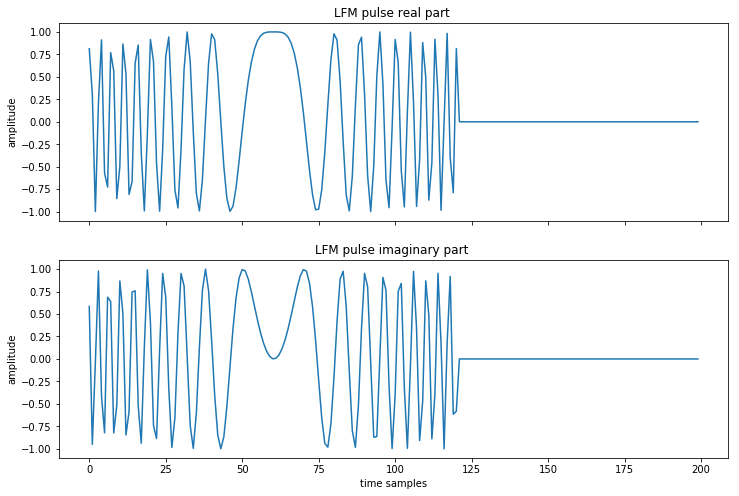

In [15]:
ps = generatePulsedLFM(A0, Tp, fc, alpha7s, tot_samples, fs)
plot_LFM_pulses(ps)

# Single Point-target simulation

By point-target, we mean that our target is of minimum size, not a complex object; and as such, it will produce one pixel in the final radar image.

The illustration below shows a squint radar, but we focus on a broadside case (squint angle is zero).

<img src="https://www.researchgate.net/profile/Kun_Shan_Chen/publication/228397725/figure/fig2/AS:299527891374082@1448424422878/Figure-2-A-typical-stripmap-SAR-observation-geometry-19.png" alt="Illustration of SAR single point-target imaging." title="Single point-target imaging." />

The vertical axis m represents the azimuth samples. The horizontal axis t represents the delay time of
the radar pulse returned from the target. Each azimuth sample (or line) corresponds
to the radar position *u* along the flight path. There are Naz number of azimuth lines
within the synthetic aperture length Ls, and Naz = int(Ls/As), where As is
the sample spacing between the azimuth lines. The azimuth location m = 1 is the
position where the radar beam starts to illuminate the target, and m = Naz is the
last position when the radar beam ceases to illuminate the target. At radar position
m = Naz/2, the target is under the center beam of the radar. This is also the position
when the target has the shortest distance from the radar. The return time of the radar
pulse starts at t1 and ends at t1 + Tp + δt. Here t1 = 2R0/c = 2R2/c is the closest
target reflection time after the radar beam is transmitted. Tp is the time duration of
the radar transmitting signal, and δt = 2(R1 − R2 )/c = 2(R3 − R2)/c is the echo
time difference between the center radar beam and the two edges of the 3-dB radar
beamwidth.

In [16]:
# closest range of the target R0 (m)
R0 = 7500
# range bandwidth B = alpha * Tp (Hz)
B = (alpha7s * Tp)
# radar moving speed (m/s)
V = 200
# azimuth FM rate = -2V*V/(R0*lambda) (Hz/s)
AFMrate = -355.56
# antenna length (m)
L = 1.0

The following parameters we can calculate from tose already given

In [18]:
# slant range sample spacing Rs = c/fs (m)
Rs = c / fs
# Radar 3-db beamwidth thetaH = lambda / L (radians)
thetaH = 0.03
# azimuth sample spacing As = V/PRF (m)
As = V / PRF
# synthetic apreture lentgh Ls = R0 thetaH (m)
Ls = R0 * thetaH
# Doppler frequency bandwidth Bdop = 2V/L (Hz)
Bdop = 400
# number of azimuth samples 
Naz = 550 # math.ceil(Ls / As)
# number of time samples within LFM pulse 
Nr = fs * Tp 
# stant range(m)
R1 = R3 = R0 / math.cos(0.5 * thetaH)

The slant range difference, namely, R 1 − R 0 = 7500.8 − 7500 = 0.8 m, is less than
1/ 4 of the range resolution, which is (c/2B)/4 = 1.56 m in this setup. Therefore, range
migration correction is not needed in this broadside SAR case.

In [19]:
def point_target_simulation(R0=R0, y=44.0, fs=fs, Naz=Naz, Mtot=Naz, Ntot=tot_samples, m=0, n=0, Tp=Tp, As=As):     
    Ttot = float(Ntot) / fs
    #pulse_samples = math.ceil(Tp * fs)
    rb = np.zeros((Mtot,Ntot)).astype(np.complex64)
    ui = 0
    for i in range(Mtot):
        tn = np.linspace(0, Ttot, Ntot)
        if i < m or i > m + Naz:
            rb[i] = tn * 0.0
        else:
            mask = abs((tn-Tp/2)/Tp)<=0.5
            thau_ui = 2 * math.sqrt((ui -  y)**2 + R0**2) / c
            rb[i] = np.exp(-1j * 2* np.pi * fc * thau_ui + 1j * np.pi * alpha7s * (tn-(Tp/2) - thau_ui)**2) * mask
        #ui_old = V * i * 1.0 / float(PRF) # other way to calculate ui, for testing
        ui = ui + As
    for i in range(Mtot):
        rb[i] = np.roll(rb[i], n)
    return rb 

In [20]:
def plot_reflected_pulses(rb):
    # two subplots, the axes array is 1-d
    f, axarr = plt.subplots(2, sharex=True)
    (M, N) = rb.shape
    x = range(0, N)
    for i in range(M):
        y1 = rb[i].real*10 + i
        y2 = rb[i].imag*10 + i  
        # try commenting these two lines to get a nice visualization of all the pulses
        if i % 30 != 0:
           continue
   
        axarr[0].plot(x, y1)
        axarr[1].plot(x, y2)
        
    axarr[0].set_title('reflected real part ')
    axarr[1].set_title('reflected imaginary part ')

    axarr[1].set_xlabel('time samples')
    axarr[0].set_ylabel('azimuth samples')
    axarr[1].set_ylabel('azimuth samples')
    axarr[1].set_ylim([-10,M])
    axarr[0].set_ylim([-10,M])
    axarr[0].set_xlim([0,N])

In [21]:
rb = point_target_simulation()

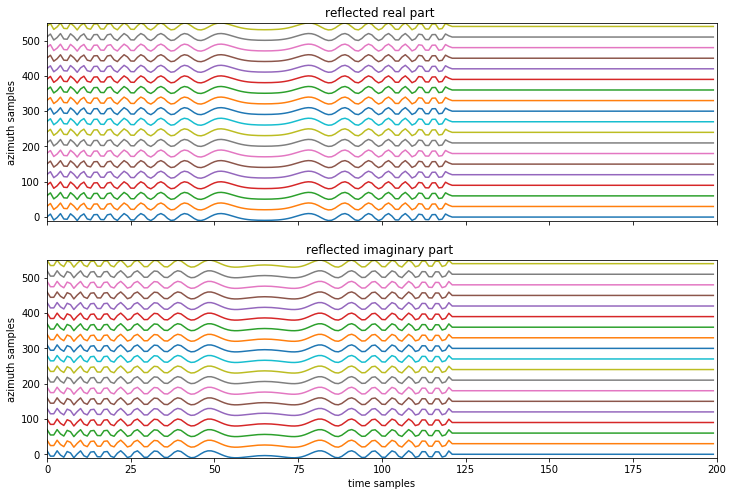

In [22]:
plot_reflected_pulses(rb)

To conclude, all these information are collected for a **single point target** and will be later assembled/processed into a **single SAR radar image pixel**.

# Multiple Point-target simulation

Below is an image which shows how SAR images targets at different point targets, but otherwise does nto correspond well to the book (could not find a better image online for now).

<img src="https://www.researchgate.net/profile/Chinmoy_Bhattacharya2/publication/268516870/figure/fig1/AS:295451019497472@1447452420125/Fig-1-FM-CW-SAR-geometry-for-stripmap-imaging.png" alt="Illustration of SAR single point-target imaging." title="Single point-target imaging." />

In [23]:
R0a = 7500
R0b = 7650
y1 = 0
y2 = 100
y3 = 150
locations_array = [(R0a,y1),(R0b,y2),(R0a,y3)]
# synthetic apreture lentgh Ls = R0 thetaH (m)
Lsa = R0a * thetaH
# synthetic apreture lentgh Ls = R0 thetaH (m)
Lsb = R0b * thetaH

# numbers of azimuth lines per target
Naza = math.floor(Lsa/As)
Nazb = math.floor(Lsb/As)
D1 = math.floor(((Lsa - (y3 - y1))/As))
D2 = math.floor((y2 - y1)/As - (Lsb - Lsa))
NRb = math.ceil((R0b - R0a)/Rs)

# number of azimuth lines
Mtot = 2 * Naza - D1
# number of time samples
Ntot = math.floor(fs * Tp) + 2 * NRb

#print (Lsa, Lsb, Naza, Nazb, D1, D2, NRb, Mtot, Ntot)

#######################################################
## these are the params we had to change compared to
## the book to make the visualizations as in the book
#######################################################
Naza = 563
Nazb = 573
D1 = 187
D2 = 244
NRb = 15

n1 = 1
n2 = 30
n3 = 1

Mtot = 939
Ntot = 211

targets = [(R0a,y1,1,Naza,n1),(R0b,y2,D2,Nazb,n2),(R0a,y3,Naza-D1+1,Naza,n3)]

ZeroDivisionError: float division by zero

In [24]:
def multiple_point_target_simulation(targets,fs=fs, Mtot=Mtot, Ntot=Ntot, Tp=Tp, As=As):
    rb = np.zeros((Mtot,Ntot)).astype(np.complex64)
    for target in targets:
        (Ri,yi,mi,Naz,ni) = target
        rb += point_target_simulation(R0=Ri, y=yi, fs=fs, Naz=Naz, Mtot=Mtot, Ntot=Ntot, m=mi, n=ni, Tp=Tp, As=As)
    return rb

NameError: name 'Mtot' is not defined

## Individual three targets

In [25]:
rb_point1 = point_target_simulation(R0=R0a, y=y1, fs=fs, Naz=Naza, Mtot=Mtot, Ntot=Ntot, m=1, n=1, Tp=Tp, As=As)
plot_reflected_pulses(rb_point1)

NameError: name 'Naza' is not defined

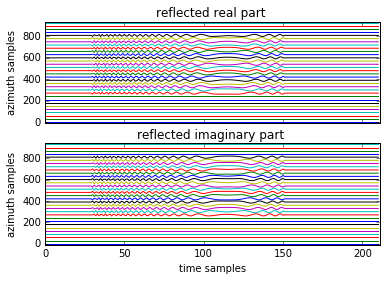

In [21]:
rb_point2 = point_target_simulation(R0=R0b, y=y2, fs=fs, Naz=Nazb, Mtot=Mtot, Ntot=Ntot, m=D2, n=30, Tp=Tp, As=As)
plot_reflected_pulses(rb_point2)

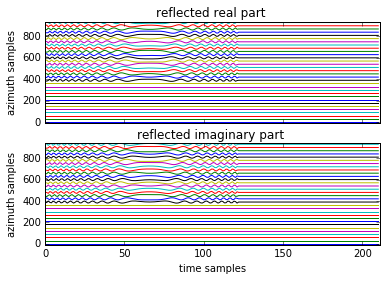

In [22]:
rb_point3 = point_target_simulation(R0=R0a, y=y3, fs=fs, Naz=Naza, Mtot=Mtot, Ntot=Ntot, m=Naza-D1+1, n=1, Tp=Tp, As=As)
plot_reflected_pulses(rb_point3)

## The sum of the signal returned from the three targets

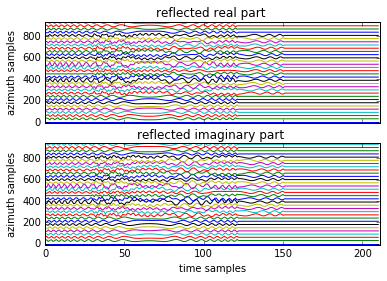

In [23]:
rb_tot = multiple_point_target_simulation(targets)
plot_reflected_pulses(rb_tot)

# range-Doppler algorithm

So the data obtained so far, both for single and mutliple targets will be processed using the range-Doppler algorithm.

In [26]:
#######################################################
## these are the params we had to change compared to
## the book to make the visualizations as in the book
#######################################################
# LFM pulse chirp rate (Range FM rate) (Hz/s)
alpha7s = 2.0e12
# number of time samples total
tot_samples = 200
# range sampling frequency
fs = 20e6
# pulse duration (s)
Tp = 6.033e-6
# radar beam carrier frequency (Hz)
fc = 1.0e10 
# amplitude
A0 = 1.0
# azimuth pulse duration time
Ta = Ls/V
# azimuth samples
########################################################
pylab.rcParams['figure.figsize'] = 20, 8  # that's default image size for this interactive session

In [27]:
def baseband_signal(Tp=Tp, fs=fs, tot_samples=tot_samples, alpha7s=alpha7s):
    Ttot = float(tot_samples) / fs
    t = np.linspace(0, Ttot, tot_samples)
    mask = abs((t-Tp/2)/Tp)<=0.5
    mask = mask.astype(int)
    #p = np.exp(1j * np.pi * alpha7s * t**2) * mask
    p = (np.exp(1j*np.pi*alpha7s*(t-Tp/2)**2)) * mask
    return p

In [28]:
def range_matched_filter(Tp=Tp, fs=fs, tot_samples=tot_samples):
    Ttot = float(tot_samples) / fs
    t = np.linspace(0, Ttot, tot_samples)
    mask = abs((t-Tp/2)/Tp)<=0.5
    mask = mask.astype(int)
    hr = np.exp(-1j * np.pi * alpha7s * (t-Tp/2)**2) * mask
    return hr

In [38]:
def azimuth_matched_filter(Ta = Ta, R0 = R0, lamd = lambd, V=V, Azfq=500, tot_samples=Naz+20):
    Ttot = float(tot_samples) / Azfq
    # change my dim
    s = np.linspace(0, Ttot, tot_samples)
    beta7s = -2 * V**2 / (lambd * R0)
    
    mask = abs((s-Ta/2)/Ta)<=0.5
    mask = mask.astype(int)
    
    ha = np.exp(-1j * np.pi * beta7s * (s-Ta/2)**2)
    return ha

In [39]:
def plot_baseband_and_matched_filters():
    # two subplots, the axes array is 1-d
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
    
    pb = baseband_signal()
    hr = range_matched_filter()
    
    N = pb.shape[0]
    assert pb.shape == hr.shape
    x = range(0, N)
    
    ax1.plot(pb.real)
    ax2.plot(pb.imag)
    
    ax3.plot(hr.real)
    ax4.plot(hr.imag)
        
    ax1.set_title('Tx pulse, real part ')
    ax2.set_title('Tx pulse, imaginary part ')
    ax3.set_title('range matched filter, real part ')
    ax4.set_title('range matched filter, imaginary part ')

    ax1.set_xlabel('time samples')
    ax1.set_ylabel('amplitutde')
    ax2.set_xlabel('time samples')
    ax2.set_ylabel('amplitutde')
    ax3.set_xlabel('time samples')
    ax3.set_ylabel('amplitutde')
    ax4.set_xlabel('time samples')
    ax4.set_ylabel('amplitutde')
    
    f2, (ax21, ax22) = plt.subplots(1, 2, sharey='row')
    
    ha = azimuth_matched_filter()
    
    M = ha.shape[0]
    x = range(0, M)
    
    ax21.plot(ha.real)
    ax22.plot(ha.imag)
    
    ax21.set_title('azimuth matched filter, real part ')
    ax22.set_title('azimuth matched filter, imaginary part ')

    ax21.set_xlabel('azimuth samples')
    ax21.set_ylabel('amplitutde')
    ax22.set_xlabel('azimuth samples')
    ax22.set_ylabel('amplitutde')

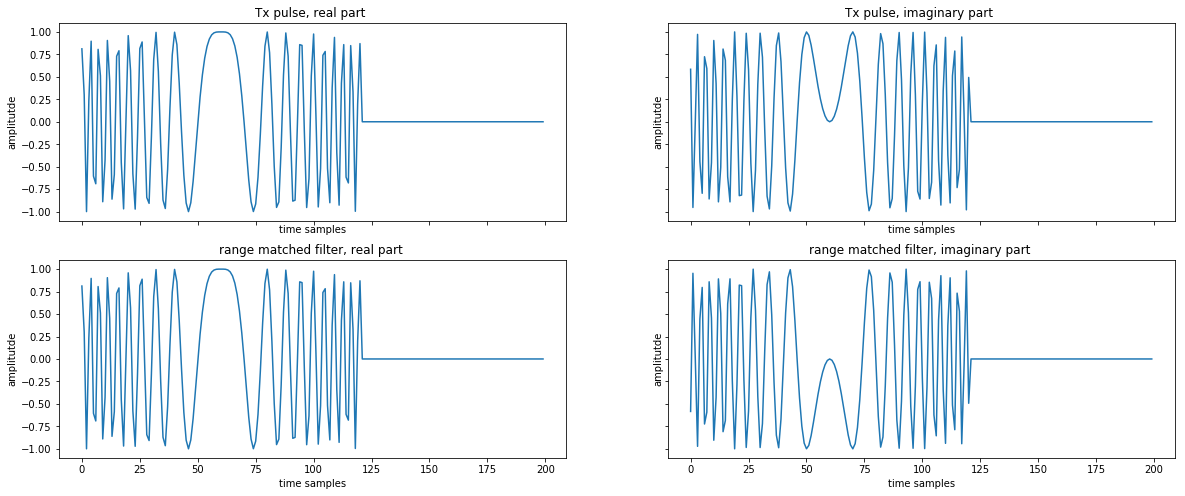

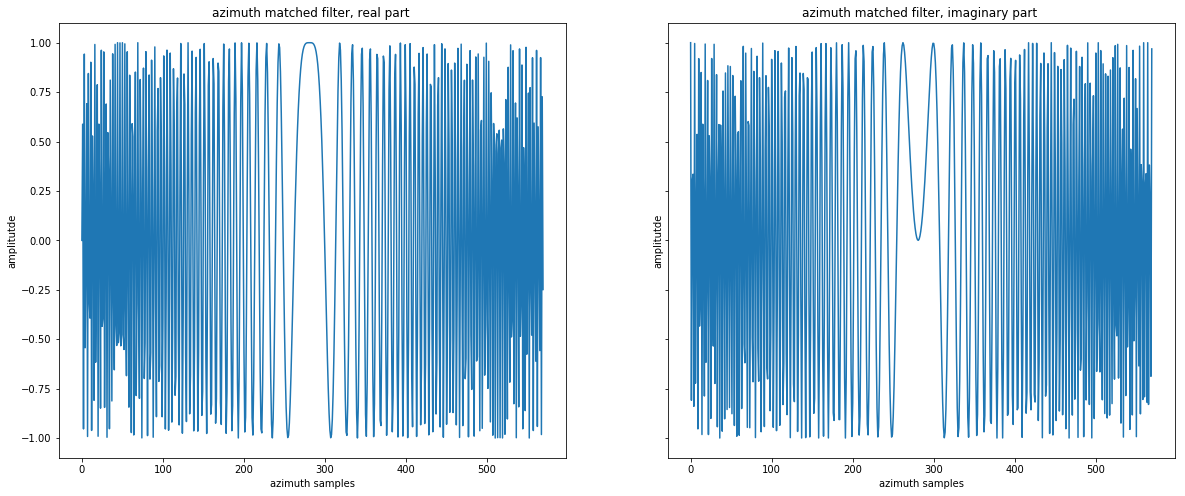

In [40]:
plot_baseband_and_matched_filters()

In [180]:
def plot_fq_spectra_of_matched_filters():

    f, (ax1, ax2) = plt.subplots(2, 1)
    
    hr = range_matched_filter()
    ha = azimuth_matched_filter()
        
    hr2 = np.fft.fftshift(np.fft.fft(hr))
    ha2 = np.fft.fftshift(np.fft.fft(ha)) 
        
    N = hr.shape[0]
    x1 = range(0, N)
    
    M = ha.shape[0]
    x2 = range(0, M)
    
    ax1.plot(abs(hr2))
    ax2.plot(abs(ha2))

    ax1.set_xlabel('frequency bins')
    ax1.set_ylabel('magnitude')
    ax2.set_xlabel('Doppler frequency bins')
    ax2.set_ylabel('magnitude')

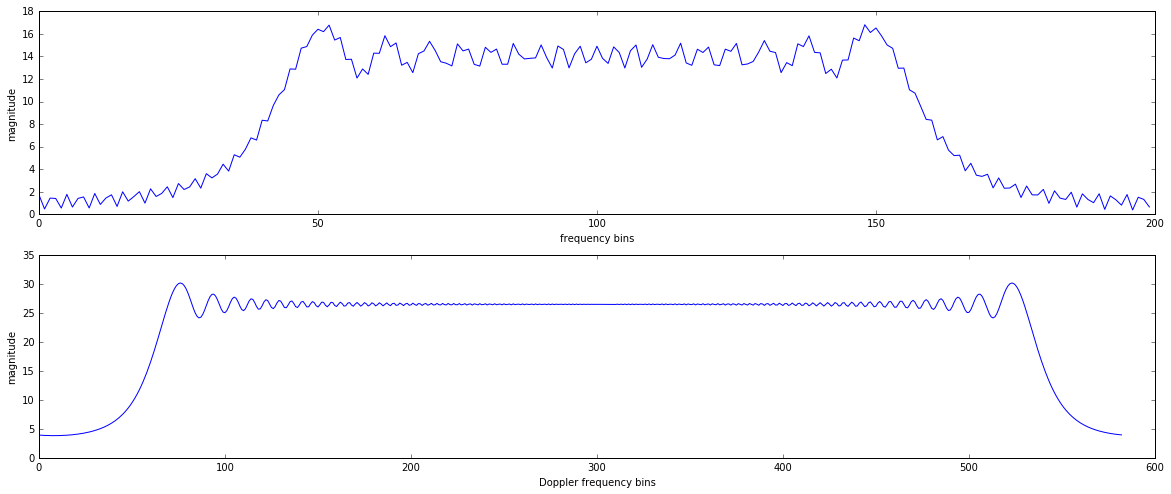

In [181]:
plot_fq_spectra_of_matched_filters()

In [212]:
def range_compression(rb):
    rb_fq = np.fft.fftshift(np.fft.fft(rb))
    hr = range_matched_filter()
    hr_fq = np.fft.fftshift(np.fft.fft(hr))   
    res = rb_fq * hr_fq
    res = (np.fft.ifft(np.fft.fftshift(res)))  
    return res

In [213]:
rb = point_target_simulation()
range_compressed_rb = range_compression(rb)

In [214]:
def plot_range_compressed_pulses(p):
    # two subplots, the axes array is 1-d
    f, axarr = plt.subplots(2, sharex=True)
    (M, N) = p.shape
    x = range(0, N)
    for i in range(M):
        y1 = p[i].real*10 + i
        y2 = p[i].imag*10 + i  
        # try commenting these two lines to get a nice visualization of all the pulses
        if i % 30 != 0:
           continue
   
        axarr[0].plot(x, y1)
        axarr[1].plot(x, y2)
        
    axarr[0].set_title('range compressed signal real part ')
    axarr[1].set_title('range compressed signal imaginary part ')

    axarr[1].set_xlabel('time samples')
    axarr[0].set_ylabel('azimuth samples')
    axarr[1].set_ylabel('azimuth samples')
    axarr[1].set_ylim([-10,M])
    axarr[0].set_ylim([-10,M])
    axarr[0].set_xlim([0,N])

In [219]:
def plot_magnitude_range_compressed_pulses(p):
    # two subplots, the axes array is 1-d
    
    (M, N) = p.shape
    x = range(0, N)
    for i in range(M):
        y1 = abs(p[i].real) + i
        
        # try commenting these two lines to get a nice visualization of all the pulses
        if i % 30 != 0:
           continue
   
        plt.plot(x, y1)

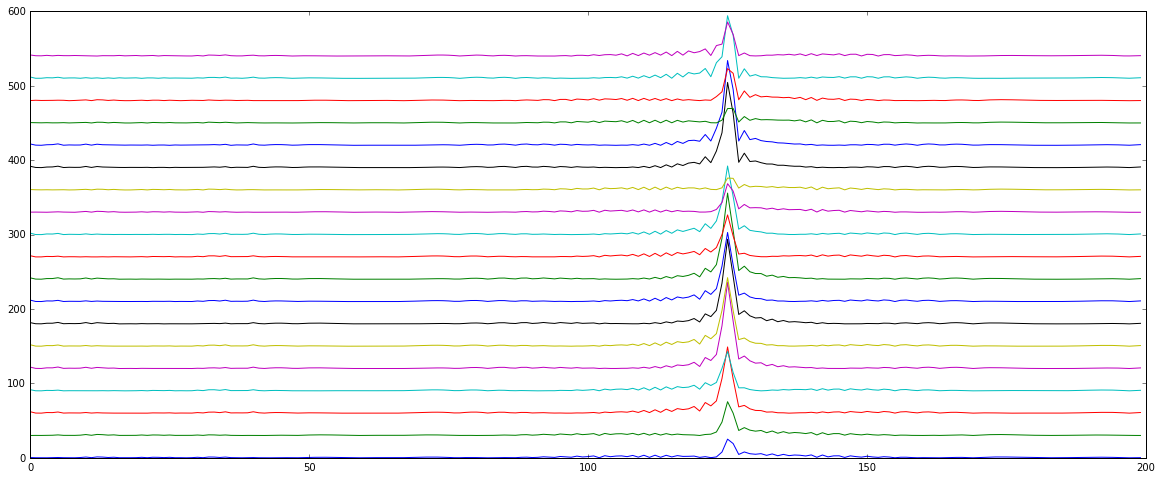

In [220]:
plot_magnitude_range_compressed_pulses(range_compressed_rb)